In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
# Veri setini yükle
df = pd.read_csv('data/haberler.csv')
df.head()

,Unnamed: 0,id,title,content,url,keywords,date,status,counter,topic
0,0,60,Sürücüsüz otomobil yola çıktı,"Modifiye otomobil 12 solar, 12 kamera, dokuz r...",https://www.ntv.com.tr/teknoloji/surucusuz-oto...,NaN,2017-11-27 15:00:01,2,2,teknoloji
1,1,63,Akıllı telefon bağımlılığına karşı 'Vekil Tele...,"Avusturyalı bir tasarımcı, akıllı telefon bağı...",https://www.ntv.com.tr/teknoloji/akilli-telefo...,NaN,2017-11-27 15:00:06,2,2,teknoloji
2,2,106,iPhone X iPhone 8 Plus'a karşı: Daha küçük kas...,8 inçlik bir ekrana ev sahipliği yapan iPhone ...,https://www.ntv.com.tr/teknoloji/iphone-x-ipho...,NaN,2017-11-28 11:00:03,2,1,teknoloji
3,3,141,Avrupa devleri hibrit elektrikli uçak için kol...,"BBC\'de yer alan habere göre, Fransız Airbus, ...",https://www.ntv.com.tr/teknoloji/avrupa-devler...,NaN,2017-11-28 20:00:07,2,0,teknoloji
4,4,158,11 yaşındaki kız 25 bin dolar değerindeki bili...,Geliştirdiği bir cihazla içme suyunun içindeki...,https://www.ntv.com.tr/teknoloji/11-yasindaki-...,NaN,2017-11-29 08:00:06,2,2,teknoloji


In [4]:
# Haber kategorileri
df['topic'].unique()

array(['teknoloji', 'sanat', 'politika', 'ekonomi', 'spor'], dtype=object)

In [6]:
# Kategori başına haber sayısı
df['topic'].value_counts()


politika     100
ekonomi      100
sanat        100
teknoloji    100
spor         100
Name: topic, dtype: int64

## TF_IDF
TF_IDF veri setimizdeki kelimelerin her konu için ne kadar önemli/karakteristik olduğunu hesaplar.

![alt text](https://www.researchgate.net/profile/Haider_Al-Khateeb2/publication/291950178/figure/fig1/AS:330186932408324@1455734107458/Term-Frequency-Inverse-Document-Frequency-TF-IDF.png)

In [0]:

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 5000,
    lowercase = True
)

tfidf.fit(df.content)
text = tfidf.transform(df.content)

### K-Means Algoritması
**Girdi:** küme sayısı k

**Çıktı:** küme merkezleri {c1, c2, ..., ck}

- Rastgele k küme merkezi ata 
- Başarı kriteri yakınsayıncaya kadar:
    - Her girdiyi küme merkezine olan uzaklığa göre en yakın kümeye ata
    - Yeni küme merkezlerini hesapla

### Optimal Küme Sayısı

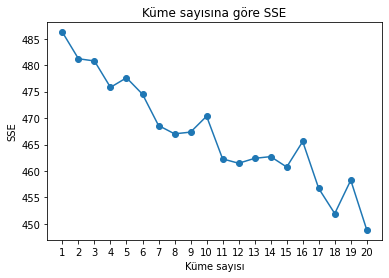

In [66]:
def find_optimal_clusters(data, max_k):
    iters = range(1, max_k+1)

    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, batch_size=16, random_state=20).fit(data).inertia_)

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Küme sayısı')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('Küme sayısına göre SSE')
    
find_optimal_clusters(text, 20)

In [0]:
clusters = MiniBatchKMeans(n_clusters=5, batch_size=16, random_state=20).fit_predict(text)

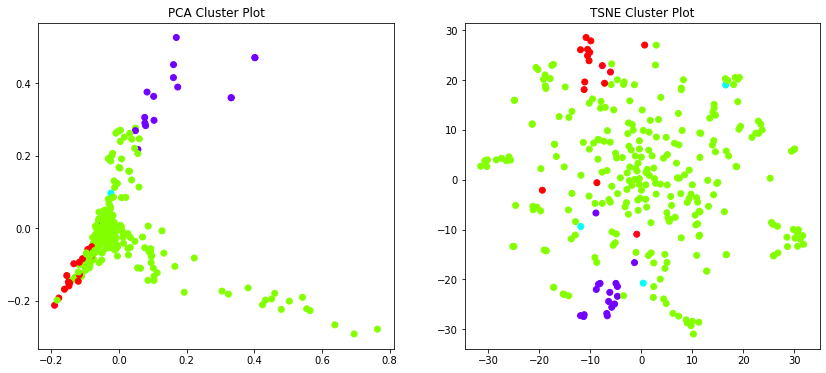

In [68]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=500, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [69]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
ın,grup,stanbul,kemal,milletvekili,başkanı,nun,genel,kılıçdaroğlu,chp

Cluster 1
dakikada,ilk,da,nin,yeni,in,türkiye,ın,de,yüzde

Cluster 2
ortaya,son,model,başkan,anlatıyor,hakkında,aşk,olacak,ali,ilk

Cluster 3
lig,yüzde,fenerbahçe,süper,sanık,aydınus,muslera,gol,galatasaray,beşiktaş

Cluster 4
polis,başlattı,soruşturma,cumhuriyet,kılıçdaroğlu,duyurusunda,suç,hakaret,cumhurbaşkanı,hakkında


### Metin Temizleme ve Dolgu Kelimelerin Çıkarılması

In [0]:
with open('data/tr-stopwords') as f:
    stopwords = f.read().splitlines()

def clean_text(text):
    text = text.strip()
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    
    text = re.sub( r'([a-zA-Z])([:;,.!?])', r'\1 \2', text)
    text = re.sub( r'([:;,.!?])([a-zA-Z])', r'\1 \2', text)
    
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r"\s+", ' ', text)

    return text

def remove_stopwords(text, stopwords):
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

In [0]:
df['content'] = df.apply(lambda row: remove_stopwords(row['content'], stopwords), axis=1)
df['content'] = df.apply(lambda row: clean_text(row['content']), axis=1)

In [72]:
df.head()

,Unnamed: 0,id,title,content,url,keywords,date,status,counter,topic
0,0,60,Sürücüsüz otomobil yola çıktı,modifiye otomobil solar kamera radar sensörü l...,https://www.ntv.com.tr/teknoloji/surucusuz-oto...,NaN,2017-11-27 15:00:01,2,2,teknoloji
1,1,63,Akıllı telefon bağımlılığına karşı 'Vekil Tele...,avusturyalı tasarımcı akıllı telefon bağımlılı...,https://www.ntv.com.tr/teknoloji/akilli-telefo...,NaN,2017-11-27 15:00:06,2,2,teknoloji
2,2,106,iPhone X iPhone 8 Plus'a karşı: Daha küçük kas...,inçlik ekrana ev sahipliği yapan iphone x appl...,https://www.ntv.com.tr/teknoloji/iphone-x-ipho...,NaN,2017-11-28 11:00:03,2,1,teknoloji
3,3,141,Avrupa devleri hibrit elektrikli uçak için kol...,bbc yer alan habere fransız airbus ngiliz roll...,https://www.ntv.com.tr/teknoloji/avrupa-devler...,NaN,2017-11-28 20:00:07,2,0,teknoloji
4,4,158,11 yaşındaki kız 25 bin dolar değerindeki bili...,geliştirdiği cihazla içme suyunun içindeki kur...,https://www.ntv.com.tr/teknoloji/11-yasindaki-...,NaN,2017-11-29 08:00:06,2,2,teknoloji


In [0]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 5000,
)
tfidf.fit(df.content)
text = tfidf.transform(df.content)

In [0]:
clusters = MiniBatchKMeans(n_clusters=5, batch_size=16, random_state=20).fit_predict(text)

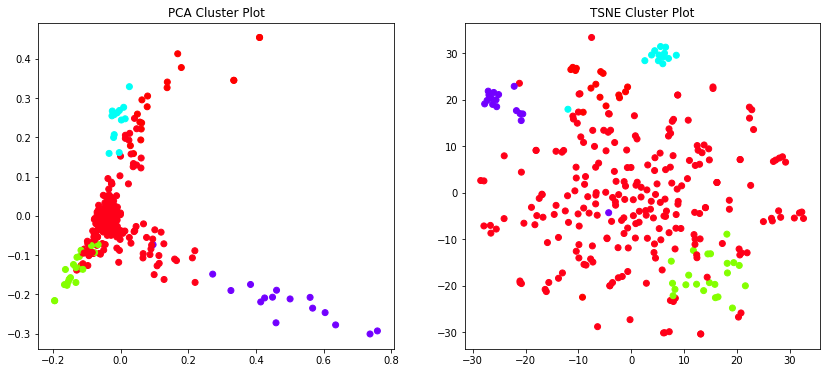

In [75]:
plot_tsne_pca(text, clusters)

In [76]:
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
takım,oynanacak,lig,fenerbahçe,muslera,maçında,süper,gol,galatasaray,beşiktaş

Cluster 1
akp,kemal,ın,başkanı,cumhurbaşkanı,sarraf,genel,erdoğan,kılıçdaroğlu,chp

Cluster 2
geçti,hızlı,başardı,fenerbahçe,önde,ilk,öne,sol,farkı,dakikada

Cluster 3
ekim,ayı,sanayi,imalat,pmi,ayında,enflasyon,kasım,endeksi,yüzde

Cluster 4
büyük,yer,devam,son,yıl,ilk,in,yeni,türkiye,ın
